# 데이터 준비

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # EOS(end of sentence) 기호 추가

def findFiles(path): return glob.glob(path)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []
for filename in findFiles('E:/Dataset/seq2seq_tutorial/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


# 네트워크 생성

이 네트워크는 지난 튜토리얼의 RNN 이 다른 입력들과 연결되는 category tensor를 추가 인자로 가지게 확장합니다. 

category tensor는 문자 입력과 마찬가지로 one-hot 벡터입니다.

**역자주: 기존 입력과 category tensor를 결합하여 입력으로 사용하기 때문에 입력의 사이즈가 n_categories 만큼 커집니다.**

우리는 출력을 다음 문자의 확률로 해석 합니다. 샘플링 할 때, 가장 확률이 높은 문자가 다음 입력 문자로 사용됩니다.

더 나은 동작을 위해 두 번째 선형 레이어 o2o (은닉과 출력을 결합한 후) 를 추가했습니다 . 또한 Drop-out 계층이 있습니다. 

이 계층은 주어진 확률(여기서는 0.1)로 무작위로 입력을 0 # 으로 만듭니다. 

일반적으로 입력을 흐리게 해서 과적합을 막는 데 사용됩니다. 

여기서 우리는 고의로 일부 혼돈을 추가하고 샘플링 다양성을 높이기 위해 네트워크의 마지막에 이것을 사용합니다.

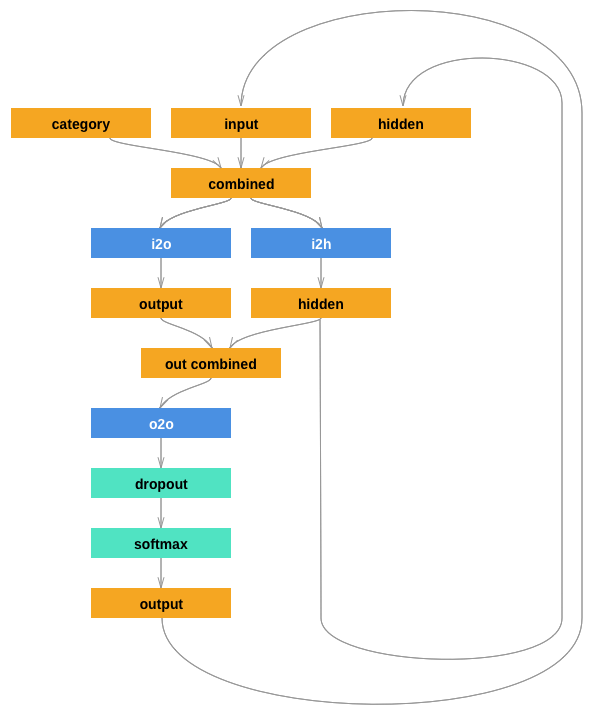'

In [2]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# 학습

제일 먼저 (category, line)의 무작위 쌍을 얻는 함수:

In [3]:
import random

# 목록에서 무작위 아이템 반환
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# 임의의 category 및 그 category에서 무작위 줄(이름) 얻기
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

각 시간 단계 마다 (즉, 학습 단어의 각 문자 마다) 네트워크의 입력은 (언어, 현재 문자, 은닉 상태) 가 되고, 출력은 (다음 문자, 다음 은닉 상태) 가 된다. 

따라서 각 학습 세트 마다 언어, 입력 문자의 세트, 출력/목표 문자의 세트가 필요하다.

각 시간 단계마다 현재 문자에서 다음 문자를 예측하기 때문에, 문자 쌍은 한 줄(하나의 이름)에서 연속된 문자 그룹입니다.

예를 들어 "ABCD<EOS>" 는 (“A”, “B”), (“B”, “C”), (“C”, “D”), (“D”, “EOS”) 로 생성합니다.

<img src='https://i.imgur.com/JH58tXY.png'>

Category(언어) Tensor는 <1 x n_categories> 크기의 One-hot Tensor 입니다. 

학습시에 모든 시간 단계에서 네트워크에 이것을 전달합니다.

이것은 설계 선택사항으로, 초기 은닉 상태 또는 또 다른 전략의 부분으로 포함될 수 있습니다.

In [4]:
# Category를 위한 One-hot 벡터
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# 입력을 위한 처음부터 마지막 문자(EOS 제외)까지의  One-hot 행렬
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# 목표를 위한 두번째 문자 부터 마지막(EOS) 까지의 LongTensor
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

학습 동안 편의를 위해 무작위로 **(category[언어], line[이름])** 을 가져오고,

그것을 필요한 형태 **(category[언어], input[현재 문자], target[다음 문자]) Tensor**로 바꾸는 randomTrainingExample 함수를 만들 예정입니다.

In [5]:
# 임의의 Category에서 Category, Input, Target Tensor를 만듭니다.
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

# 네트워크 학습

마지막 출력만 사용하는 분류와 달리, 모든 단계에서 예측을 수행하므로 모든 단계에서 손실을 계산합니다.

Autograd의 마법이 각 단계의 손실들을 간단하게 합하고 마지막에 역전파를 호출하게 해줍니다.

In [6]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

학습에 걸리는 시간을 추적하기 위해 사람이 읽을 수 있는 문자열을 반환하는``timeSince (timestamp)`` 함수를 추가합니다

In [7]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

학습은 일상적인 일입니다.

몇번 train() 을 호출하고, 몇 분 정도 기다렸다가 print_every 마다 현재 시간과 손실을 출력하고, 나중에 도식화를 위해 plot_every 마다 all_losses 에 평균 손실을 저장합니다.

In [8]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # plot_every 마다 초기화

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 12s (5000 5%) 2.4150
0m 24s (10000 10%) 2.3635
0m 37s (15000 15%) 2.6780
0m 49s (20000 20%) 2.3839
1m 2s (25000 25%) 3.1087
1m 14s (30000 30%) 2.8529
1m 26s (35000 35%) 2.8906
1m 38s (40000 40%) 2.5796
1m 51s (45000 45%) 2.2866
2m 3s (50000 50%) 2.3517
2m 15s (55000 55%) 2.0681
2m 28s (60000 60%) 3.4222
2m 41s (65000 65%) 2.3667
2m 54s (70000 70%) 2.1545
3m 7s (75000 75%) 2.9324
3m 20s (80000 80%) 2.3145
3m 33s (85000 85%) 2.6628
3m 46s (90000 90%) 2.6399
3m 58s (95000 95%) 2.2561
4m 11s (100000 100%) 2.1057
